<a href="https://colab.research.google.com/github/anujdutt9/Deep-Learning-TF-2.0/blob/master/TF_2_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import Dependencies
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Check Tensorflow Version
tf.__version__

'2.2.0-rc3'

In [0]:
# Load Training Dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
# Reshape and Normalize the Images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
# Total number of training samples
len(train_images)

60000

In [0]:
# Buffer Size and Batch Size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# Define Generator Model Architecture
def generator_model(inputSize=None):
  model = tf.keras.Sequential([# Layer-1: Input Data
                               tf.keras.layers.Dense(units=7*7*256, use_bias=False, input_shape=(inputSize,)),
                               # Apply Batch Normalization
                               tf.keras.layers.BatchNormalization(),
                               # ReLU Activation
                               tf.keras.layers.ReLU(),
                               # Reshape First Layer output for Convolutions
                               tf.keras.layers.Reshape(target_shape=(7,7,256)),
                               
                               # Layer-2: Transposed Convolution with 128 filters and 5x5 kernel
                               tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False),
                               # Apply Batch Normalization
                               tf.keras.layers.BatchNormalization(),
                               # ReLU Activation
                               tf.keras.layers.ReLU(),

                               # Layer-3: Transposed Convolution with 64 filters
                               tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False),
                               # Apply Batch Normalization
                               tf.keras.layers.BatchNormalization(),
                               # ReLU Activation
                               tf.keras.layers.ReLU(),

                               # Layer-4: Transposed Convolution with 1 filter
                               tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
                               ])
  return model

In [9]:
# Check Generator Model Summary
generator = generator_model(inputSize=100)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 128)         0

Random Noise Signal:  tf.Tensor(
[[-0.27348173  1.2011085   0.07098164  0.05374254 -0.14608134 -0.5966157
  -0.6141177   0.15190865  0.7476294   0.9617047   0.39307597  0.51563096
   0.8843892   0.23583266  0.8917288  -0.20548497  1.3620983  -0.7109142
   1.2050438  -0.10386036 -2.09754     0.28006423 -0.0815015   1.4408284
   0.5530156   0.1865511   0.43813756 -1.0923637  -1.1756434  -0.06546151
   0.9166289  -0.23003414 -0.19069476  0.01336357  0.42455676 -0.73125446
   0.25713855 -1.5697479  -0.41069284  0.9581596  -0.14765488 -0.25184548
  -0.6346997   0.9868398   0.04051164  0.5522304   0.65127    -1.4827297
  -0.7053389   0.2656514   0.14468889 -0.3830521  -0.28678578 -0.12615164
  -0.4381194   0.28668827  0.27643877  0.36091554 -0.85821754 -1.729595
   1.1027663  -0.2980468  -0.8375254  -0.77167153 -1.6978428   0.6068779
   0.9781258   0.37404796  1.4328766  -0.5091301   0.6004171  -0.18822531
  -2.406831    0.81456596 -0.1956512   1.3170844  -0.48615336 -0.6866907
   1.7803954 

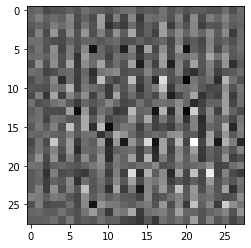

In [10]:
# Generate Random Noise Signal
noise = tf.random.normal([1, 100])
print("Random Noise Signal: ", noise)

# Pass the Noise as Input to the Un-trained Generator Model
generated_image = generator(noise, training=False)
print("Shape of generated Image: ", generated_image.numpy().shape)
print("\n")

# Plot the output of the Untrained Generator Model
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
# Discriminator Model Architecture
def discriminator_model(leakSlope=None):
  model = tf.keras.Sequential([# Layer-1: Generated Image of shape (28,28,1)
                               tf.keras.layers.InputLayer(input_shape=(28,28,1)),
                               # 2D Convolution
                               tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same'),
                               # LeakyRelu with Slope of "leakSlope"
                               tf.keras.layers.LeakyReLU(alpha=leakSlope),
                               # Dropout
                               tf.keras.layers.Dropout(rate=0.3),

                               # Layer-2: 2D Convolution with 128 filters
                               tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'),
                               # LeakyRelu with Slope of "leakSlope"
                               tf.keras.layers.LeakyReLU(alpha=leakSlope),
                               # Dropout
                               tf.keras.layers.Dropout(rate=0.3),

                               # Layer-3: Output Layer
                               tf.keras.layers.Flatten(),
                               # Dense Layer
                               tf.keras.layers.Dense(units=1)
                               ])
  return model

In [12]:
# Check Discriminator Model Summary
discriminator = discriminator_model(leakSlope=0.2)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
# Test Untrained Discriminator Model on Untrained Generator Output
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00183671]], dtype=float32)>

In [0]:
# Loss Function: Binary Crossentropy with Logits
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discrimintaor Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
# Discriminator Loss Function
# Compares Discriminator Output on Real Images with 1's and for Fake Images with 0's
def discriminator_loss(real_output, fake_output):
  # Loss on Real Images
  real_loss = loss(tf.ones_like(real_output), real_output)
  # Loss on Fake Images
  fake_loss = loss(tf.zeros_like(fake_output), fake_output)
  # Total Loss
  total_loss = real_loss + fake_loss
  return total_loss

# Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
  # Compare which fake images are classified by the disciminator as Real Image
  return loss(tf.ones_like(fake_output), fake_output)

In [0]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# Save Model Training Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Train the Model
# Epochs
EPOCHS = 100

# Noise Dimension
noise_dim = 100

# Number of examples to generate
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Generate Random Noise of size: (batch_size, input_dim)
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # At every training step or epoch, keep track of the generator and discriminator gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Pass in the Generated Noise signal as input to the Generator and
      # get the Generator Output of shape: (batch_size, 28, 28, 1)
      generated_images = generator(noise, training=True)

      # Forward Pass the image from the training dataset to the discriminator
      # and get the discriminator output [Real Output]
      real_output = discriminator(images, training=True)
      # Forward Pass the Generated Noise to the discriminator
      # and get the discriminator output [Fake Output]
      fake_output = discriminator(generated_images, training=True)

      # Get the Generator Loss using the fake output from the Discriminator.
      # If the Generator has successfully fooled the Discriminator, the gen_loss
      # will be a small value
      gen_loss = generator_loss(fake_output)
      # Get the Discriminator Loss i.e. how well the Discriminator is able to 
      # classify between real and fake images
      disc_loss = discriminator_loss(real_output, fake_output)

    # Get the Gradients of Generator Loss w.r.t all Generator Variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Get the Gradients of Discriminator Loss w.r.t all Discriminator Variables
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Backpropagate the error through the Generator and Discriminator Models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
# Train the Model
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

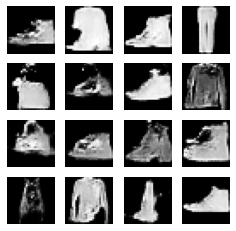

In [23]:
# Train the Model
train(train_dataset, EPOCHS)

In [0]:
# Save Generator Model
generator.save("generator_model.h5")

# Save Discriminator Model
discriminator.save("discriminator_model.h5")

In [25]:
# Load the Trained Model from Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
import PIL

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

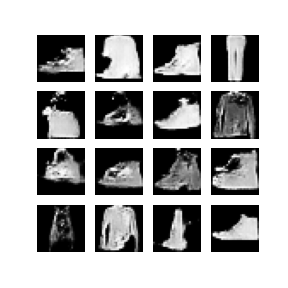

In [27]:
display_image(EPOCHS)

In [0]:
# Generate a gif file from training
import glob
import imageio

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
# Download generated DCGAN gif file
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)